In [1]:
from qaoa import *
import matplotlib.pyplot as plt



In [2]:
# Example 1: Creating an Ising Hamiltonian and Finding Fisher Information Matrix
# Set a random seed for reproducibility
np.random.seed(42)

# Define the number of qubits and connectivity type ("open" or "closed")
n_qubits = 4
connectivity = "closed"

# Create an Ising Hamiltonian
ising_hamiltonian = H_zz_Ising(n_qubits, connectivity)

depth = 1
# Initialize QAOA with a specific depth and the Ising Hamiltonian
qaoa = QAOA(depth=depth, H=ising_hamiltonian)

# Define a set of parameters
angles = [0.5, 0.2]*depth  # Adjust these parameters as needed

# Calculate the Fisher Information Matrix
qfi_matrix = qaoa.qaoa_qfi_matrix(angles, state_ini=plus_state(n_qubits)) #|+>

print("Fisher Information Matrix:")
with np.printoptions(precision=3, suppress=True):
    print(qfi_matrix)


Fisher Information Matrix:
[[16.     0.   ]
 [ 0.    29.273]]


In [3]:
# Example 2: Creating a k-SAT Hamiltonian and Optimizing it with QAOA
# Set a random seed for reproducibility
np.random.seed(42)
# Define the number of variables (n), clauses (k), and alpha for k-SAT Hamiltonian
n = 5
k = 3
alpha = 2.0

# Create a k-SAT Hamiltonian
k_sat_hamiltonian = H_sat(n, k, alpha)

depth = 2
# Initialize QAOA with a specific depth and the k-SAT Hamiltonian
qaoa = QAOA(depth=depth, H=k_sat_hamiltonian)


# Run the QAOA optimization using the L-BFGS-B method
qaoa.run()

# Print the optimization results
with np.printoptions(precision=3, suppress=True):
    print("QAOA Parameters:", qaoa.opt_angles)
    print("Optimized QAOA Energy:", qaoa.q_energy)


QAOA Parameters: [1.261 3.682 1.142 1.765]
Optimized QAOA Energy: 0.5039655121265381


In [4]:
# Example 3: Solving the Max Cut Problem
# Set a random seed for reproducibility
np.random.seed(42)
# Define the graph adjacency matrix (replace this with your specific graph)
graph = [
    [0, 1, 1, 0],
    [1, 0, 0, 1],
    [1, 0, 0, 1],
    [0, 1, 1, 0]
]

# Number of qubits, which is the same as the number of nodes in the graph will be calculated inside the function
# Convert the graph into the corresponding Ising Hamiltonian
max_cut_hamiltonian = Graph_to_Hamiltonian(graph)

depth = 4
# Now you can use your QAOA solver to find the maximum cut
qaoa = QAOA(depth=depth, H=max_cut_hamiltonian)
qaoa.run()

# Extract the results
max_cut_solution = qaoa.f_state  # The quantum state
max_cut_value = qaoa.q_energy  # The value of the maximum cut

# Output the results
with np.printoptions(precision=3, suppress=True):
    print("Max Cut Solution (quantum state):\n", max_cut_solution)
    print("Max Cut Value:", max_cut_value)

Max Cut Solution (quantum state):
 [-0.   -0.j     0.   +0.j     0.   +0.j     0.   -0.j     0.   +0.j
  0.   -0.j     0.176-0.685j  0.   +0.j     0.   +0.j     0.176-0.685j
  0.   -0.j     0.   +0.j     0.   -0.j     0.   +0.j     0.   +0.j
 -0.   -0.j   ]
Max Cut Value: -3.9999999999998725


In [5]:
# Example 4: Solving the Max Cut Problem with PROTES method 
# Set a random seed for reproducibility
np.random.seed(42)
# Define the graph adjacency matrix (replace this with your specific graph)
graph = [
    [0, 1, 1, 0],
    [1, 0, 0, 1],
    [1, 0, 0, 1],
    [0, 1, 1, 0]
]

# Number of qubits, which is the same as the number of nodes in the graph will be calculated inside the function
# Convert the graph into the corresponding Ising Hamiltonian
max_cut_hamiltonian = Graph_to_Hamiltonian(graph)

depth = 4
# Now you can use your QAOA solver to find the maximum cut
qaoa = QAOA(depth=depth, H=max_cut_hamiltonian)
#run the PROTES method 
qaoa.run_PROTES()

# Extract the results
max_cut_solution = qaoa.f_state  # The quantum state
max_cut_value = qaoa.q_energy  # The value of the maximum cut

# Output the results
with np.printoptions(precision=3, suppress=True):
    print("Max Cut Solution (quantum state):\n", max_cut_solution)
    print("Max Cut Value:", max_cut_value)

# for the PROTES only method there is a special value protes_log stored in qaoa
# Print additional information from PROTES log
protes_log = qaoa.protes_log
print("Time to execute:", protes_log['t'])
print("Minimum Candidates:")
for i, (i_opt, y_opt) in enumerate(zip(protes_log['i_opt_list'], protes_log['y_opt_list']), 1):
    angles = 360 * i_opt/100  # if you change linspace params inside protes then you have to change it here for the right plot
    print(f" Angles: {angles}°, Value: {y_opt}")

Max Cut Solution (quantum state):
 [-0.01 -0.011j  0.039+0.032j  0.039+0.032j  0.015+0.094j  0.039+0.032j
  0.015+0.094j -0.567+0.387j  0.039+0.032j  0.039+0.032j -0.567+0.387j
  0.015+0.094j  0.039+0.032j  0.015+0.094j  0.039+0.032j  0.039+0.032j
 -0.01 -0.011j]
Max Cut Value: -3.7690287
Time to execute: 32.19320000009611
Minimum Candidates:
 Angles: [136.8 262.8 295.2 176.4 306.  198.   75.6 165.6]°, Value: -3.4218239784240723
 Angles: [ 43.2 316.8  86.4  18.  104.4 111.6 244.8 237.6]°, Value: -3.63492751121521
 Angles: [356.4  28.8 144.  147.6 104.4 198.   39.6 309.6]°, Value: -3.685230255126953
 Angles: [226.8 248.4 147.6 216.  108.  165.6  86.4 248.4]°, Value: -3.769028663635254


In [6]:
# Example 5: Calculate the Average Expectation with Noise
# Set a random seed for reproducibility
np.random.seed(42)
# Define the number of qubits and connectivity type ("open" or "closed")
n_qubits = 4
connectivity = "closed"

# Define the depth of the QAOA circuit
depth = 2

# Create an Ising Hamiltonian
ising_hamiltonian = H_zz_Ising(n_qubits, connectivity)

# Initialize QAOA with a specific depth and the Ising Hamiltonian
qaoa = QAOA(depth=depth, H=ising_hamiltonian)


# Find optimum angles
qaoa = QAOA(depth=depth, H=ising_hamiltonian)
qaoa.run()
angles = qaoa.opt_angles  # Adjust these parameters as needed

# Create Kraus operators and probabilities for the depolarization channel
p_depolarization = 0.01  # Adjust the depolarization probability
depolarization_kraus_ops, depolarization_probabilities = create_depolarization_kraus(p_depolarization)


# Apply the QAOA ansatz with depolarization noise
state_with_noise = qaoa.expectation_noise(angles, noise_prob=depolarization_probabilities, kraus_ops=depolarization_kraus_ops,num_samples=100)

# Print the state vector with depolarization noise
print("Average Expectation with Depolarization Noise:",state_with_noise)
print("Expectation without Noise:", qaoa.expectation(angles))

Average Expectation with Depolarization Noise: -0.7456951709806164
Expectation without Noise: -1.9999999999998663


In [7]:
# help function to plot results:
def plot_cost_functions(arrays, names, title=None):
    colors = plt.cm.tab10.colors  # Using a default colormap for colors
    num_arrays = len(arrays)

    plt.figure(figsize=(10, 10))

    for i in range(num_arrays):
        values = arrays[i]
        label = names[i]

        # Automatically assign colors
        color_index = i % len(colors)
        color = colors[color_index]

        plt.plot(np.arange(len(values)), values, label=label, alpha=0.5, color=color, linewidth=0.5)

        # Plot step functions representing the minimum found so far for each method
        buf = 0
        min_val = values[0]
        for j in range(1, len(values)):
            if values[j] < min_val:
                plt.plot([buf, j + 1], [min_val, min_val], color=color, linestyle='-', linewidth=3, alpha=0.9)
                min_val = values[j]
                buf = j
            if j == len(values)-1:
                plt.plot([buf, j + 1], [min_val, min_val], color=color, linestyle='-', linewidth=3, alpha=0.9)

        # Annotate the global minimum on the right side of the plot
        plt.annotate(f'{min_val:.2f}', xy=(len(values) - 1, min_val), xytext=(len(values) + 20, min_val),
                     color=color, fontsize=12, ha='left', va='center')

    # Add grid lines
    plt.grid(True)

    # Adjust y-axis label to be on the right side
    plt.ylabel('Cost Function')

    plt.xlabel('Number of Evaluations')
    if title == None:
        plt.title('Cost Function vs. Number of Evaluations')
    else:
        plt.title(title)
    # Set legend with thicker lines
    legend = plt.legend()
    for line in legend.get_lines():
        line.set_linewidth(3)  # Set thicker lines for the legend
        line.set_alpha(1)
    plt.show()

Time to perform the regular L-BFGS-B method:  0.11358904838562012
Found optimal angles: [3.37872841 2.31390739 1.09260336 2.80380512 1.27678658 2.58984116]
------------
Time to perform the natural gradient strategy:  0.05077338218688965
Found optimal angles: [0.92577489 1.87082075 2.80327795 2.04314096 2.26465199 2.66736909]
------------
Time to perform the layer-wise learning:  1.1604225635528564
Found optimal angles: [5.36867707 4.72770554 0.58713693 0.8366232  0.71622746 2.85995847]
------------
Time to perform the PROTES method:  25.490362405776978
Found optimal angles: [5.2778754 4.712389  2.5132742 3.895575  3.3929203 2.953097 ]
------------


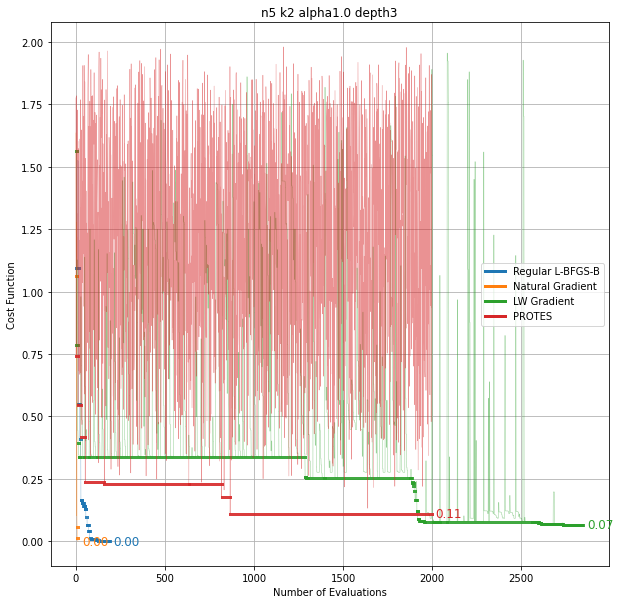

In [8]:
# Example 5.1: Compare optimization strategies
# The crucial part is not only the found minimum but also the number of evaluations required 

np.random.seed(25)
# Define the number of variables (n), clauses (k), and alpha for k-SAT Hamiltonian
n = 5
k = 2
alpha = 1.0

# Create a k-SAT Hamiltonian
k_sat_hamiltonian = H_sat(n, k, alpha)
depth = 3

# Initialize QAOA with a specific depth and the k-SAT Hamiltonian
qaoa = QAOA(depth=depth, H=k_sat_hamiltonian)
qaoa.track_cost = True
# Run optimization using the regular L-BFGS-B method
qaoa.run()
cost_values_reg = np.copy(qaoa.tracked_cost)
qaoa.tracked_cost = []
print('Time to perform the regular L-BFGS-B method: ', qaoa.exe_time)
print('Found optimal angles:', qaoa.opt_angles)
print('------------')
# Run optimization using the natural gradient strategy
qaoa.run_QFI()
cost_values_natgrad = np.copy(qaoa.tracked_cost)
qaoa.tracked_cost = []
print('Time to perform the natural gradient strategy: ', qaoa.exe_time)
print('Found optimal angles:', qaoa.opt_angles)
print('------------')
# Run optimization using the layer-wise learning
qaoa.run_heuristic_LW()
cost_values_lw = np.copy(qaoa.tracked_cost)
qaoa.tracked_cost = []
print('Time to perform the layer-wise learning: ', qaoa.exe_time)
print('Found optimal angles:', qaoa.opt_angles)
print('------------')
# Run optimization using the PROTES method
qaoa.run_PROTES()
cost_values_protes = np.copy(qaoa.tracked_cost)
qaoa.tracked_cost = []
print('Time to perform the PROTES method: ', qaoa.exe_time)
print('Found optimal angles:', qaoa.opt_angles)
print('------------')

# Plot cost functions for comparison
plot_cost_functions([cost_values_reg, cost_values_natgrad, cost_values_lw, cost_values_protes],
                    ['Regular L-BFGS-B', 'Natural Gradient', 'LW Gradient', 'PROTES'], f'n{n} k{k} alpha{alpha} depth{depth}')

Time to perform the regular L-BFGS-B method:  0.11447882652282715
Found optimal angles: [2.87397835 2.16211275 2.74558355 1.71701189 2.17349749 2.58384039]
------------
Time to perform the natural gradient strategy:  0.7760326862335205
Found optimal angles: [0.46631426 0.92023051 1.13177592 2.68834753 2.85300973 2.98888517]
------------
Time to perform the layer-wise learning:  1.483609676361084
Found optimal angles: [0.82296091 4.69128706 5.15177858 2.98333373 0.27837393 0.16023701]
------------
Time to perform the PROTES method:  25.077425003051758
Found optimal angles: [0.         0.87964594 4.712389   0.87964594 3.0787609  0.25132743]
------------


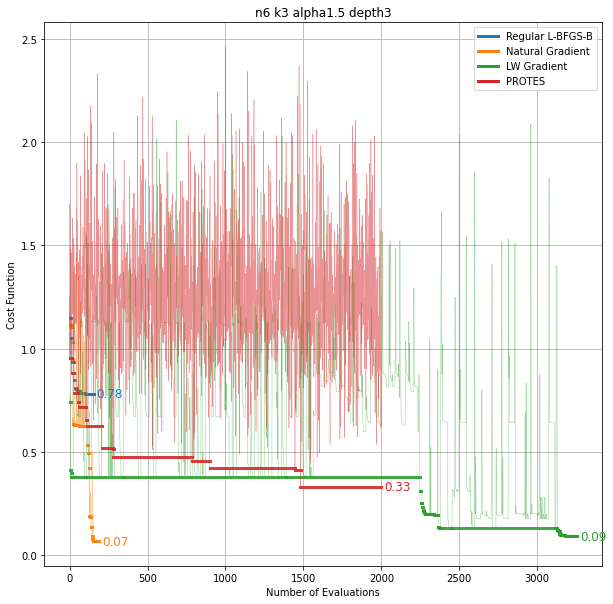

In [9]:
# Example 5.2: Compare optimization strategies
np.random.seed(25)

# Define the number of variables (n), clauses (k), and alpha for k-SAT Hamiltonian
n = 6
k = 3
alpha = 1.5

# Create a k-SAT Hamiltonian
k_sat_hamiltonian = H_sat(n, k, alpha)
depth = 3


# Initialize QAOA with a specific depth and the k-SAT Hamiltonian
qaoa = QAOA(depth=depth, H=k_sat_hamiltonian)
qaoa.track_cost = True
# Run optimization using the regular L-BFGS-B method
qaoa.run()
cost_values_reg = np.copy(qaoa.tracked_cost)
qaoa.tracked_cost = []
print('Time to perform the regular L-BFGS-B method: ', qaoa.exe_time)
print('Found optimal angles:', qaoa.opt_angles)
print('------------')
# Run optimization using the natural gradient strategy
qaoa.run_QFI()
cost_values_natgrad = np.copy(qaoa.tracked_cost)
qaoa.tracked_cost = []
print('Time to perform the natural gradient strategy: ', qaoa.exe_time)
print('Found optimal angles:', qaoa.opt_angles)
print('------------')
# Run optimization using the layer-wise learning
qaoa.run_heuristic_LW()
cost_values_lw = np.copy(qaoa.tracked_cost)
qaoa.tracked_cost = []
print('Time to perform the layer-wise learning: ', qaoa.exe_time)
print('Found optimal angles:', qaoa.opt_angles)
print('------------')
# Run optimization using the PROTES method
qaoa.run_PROTES()
cost_values_protes = np.copy(qaoa.tracked_cost)
qaoa.tracked_cost = []
print('Time to perform the PROTES method: ', qaoa.exe_time)
print('Found optimal angles:', qaoa.opt_angles)
print('------------')

# Plot cost functions for comparison
plot_cost_functions([cost_values_reg, cost_values_natgrad, cost_values_lw, cost_values_protes],
                    ['Regular L-BFGS-B', 'Natural Gradient', 'LW Gradient', 'PROTES'], f'n{n} k{k} alpha{alpha} depth{depth}')

Time to perform the regular L-BFGS-B method:  0.4380621910095215
Found optimal angles: [1.25486303 1.576368   1.93482427 1.42281134 1.8660431  1.26865068
 0.97112009 2.52205864 2.32713334 0.        ]
------------
Time to perform the natural gradient strategy:  0.4261777400970459
Found optimal angles: [2.71168505 1.03731414 2.48276584 3.37244085 1.5383418  0.63184068
 0.41359842 0.61234203 1.75413007 0.42232709]
------------
Time to perform the layer-wise learning:  2.6969244480133057
Found optimal angles: [0.68347497 5.17655434 5.59364599 5.49382333 5.42381462 3.06602042
 0.40918265 0.3100649  0.20304625 0.11661058]
------------
Time to perform the PROTES method:  44.6702036857605
Found optimal angles: [0.5654867  0.25132743 5.8433623  0.37699112 0.6911504  2.5132742
 1.3823009  6.1575217  5.4035397  5.906194  ]
------------


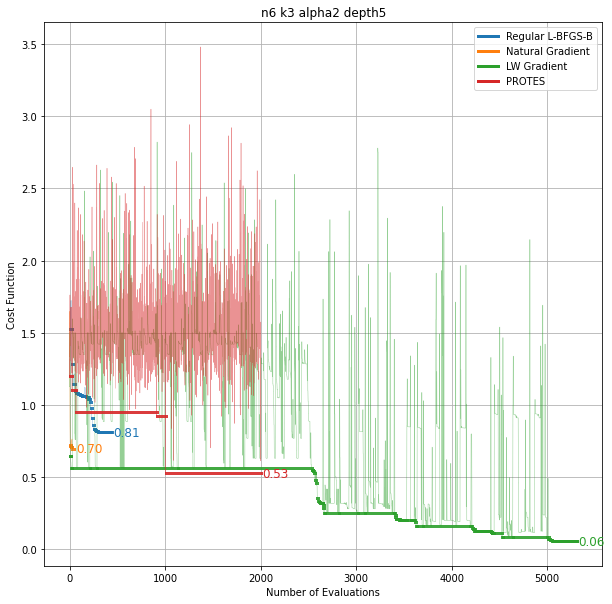

In [10]:
# Example 5.3: Compare optimization strategies
np.random.seed(25)

# Define the number of variables (n), clauses (k), and alpha for k-SAT Hamiltonian
n = 6
k = 3
alpha = 2

# Create a k-SAT Hamiltonian
k_sat_hamiltonian = H_sat(n, k, alpha)
depth = 5


# Initialize QAOA with a specific depth and the k-SAT Hamiltonian
qaoa = QAOA(depth=depth, H=k_sat_hamiltonian)
qaoa.track_cost = True
# Run optimization using the regular L-BFGS-B method
qaoa.run()
cost_values_reg = np.copy(qaoa.tracked_cost)
qaoa.tracked_cost = []
print('Time to perform the regular L-BFGS-B method: ', qaoa.exe_time)
print('Found optimal angles:', qaoa.opt_angles)
print('------------')
# Run optimization using the natural gradient strategy
qaoa.run_QFI()
cost_values_natgrad = np.copy(qaoa.tracked_cost)
qaoa.tracked_cost = []
print('Time to perform the natural gradient strategy: ', qaoa.exe_time)
print('Found optimal angles:', qaoa.opt_angles)
print('------------')
# Run optimization using the layer-wise learning
qaoa.run_heuristic_LW()
cost_values_lw = np.copy(qaoa.tracked_cost)
qaoa.tracked_cost = []
print('Time to perform the layer-wise learning: ', qaoa.exe_time)
print('Found optimal angles:', qaoa.opt_angles)
print('------------')
# Run optimization using the PROTES method
qaoa.run_PROTES()
cost_values_protes = np.copy(qaoa.tracked_cost)
qaoa.tracked_cost = []
print('Time to perform the PROTES method: ', qaoa.exe_time)
print('Found optimal angles:', qaoa.opt_angles)
print('------------')


# Plot cost functions for comparison
plot_cost_functions([cost_values_reg, cost_values_natgrad, cost_values_lw, cost_values_protes],
                    ['Regular L-BFGS-B', 'Natural Gradient', 'LW Gradient', 'PROTES'], f'n{n} k{k} alpha{alpha} depth{depth}')

Time to perform the regular L-BFGS-B method:  0.1181483268737793
Found optimal angles: [0.43460584 0.73421684 2.26830122 0.80499161 1.96396717 0.04131662]
------------
Time to perform the natural gradient strategy:  0.3174567222595215
Found optimal angles: [1.76853564 1.96338701 2.55195578 1.57185336 1.57049158 0.7842452 ]
------------
Time to perform the layer-wise learning:  1.0463790893554688
Found optimal angles: [5.67873522 0.67386621 4.92557861 0.64622489 0.14298993 0.33224731]
------------
Time to perform the PROTES method:  24.58174967765808
Found optimal angles: [0.         1.0681416  5.0893803  0.87964594 1.4451327  5.5292034 ]
------------


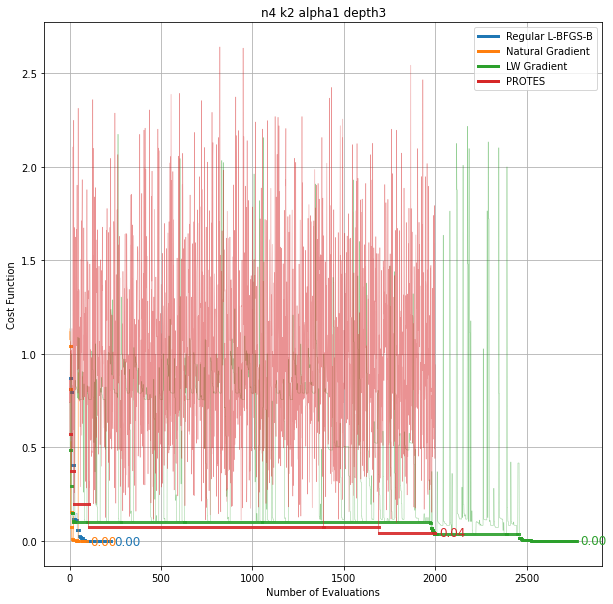

In [11]:
# Example 5.4: Compare optimization strategies
np.random.seed(25)

# Define the number of variables (n), clauses (k), and alpha for k-SAT Hamiltonian
n = 4
k = 2
alpha = 1

# Create a k-SAT Hamiltonian
k_sat_hamiltonian = H_sat(n, k, alpha)
depth = 3


# Initialize QAOA with a specific depth and the k-SAT Hamiltonian
qaoa = QAOA(depth=depth, H=k_sat_hamiltonian)
qaoa.track_cost = True
# Run optimization using the regular L-BFGS-B method
qaoa.run()
cost_values_reg = np.copy(qaoa.tracked_cost)
qaoa.tracked_cost = []
print('Time to perform the regular L-BFGS-B method: ', qaoa.exe_time)
print('Found optimal angles:', qaoa.opt_angles)
print('------------')
# Run optimization using the natural gradient strategy
qaoa.run_QFI()
cost_values_natgrad = np.copy(qaoa.tracked_cost)
qaoa.tracked_cost = []
print('Time to perform the natural gradient strategy: ', qaoa.exe_time)
print('Found optimal angles:', qaoa.opt_angles)
print('------------')
# Run optimization using the layer-wise learning
qaoa.run_heuristic_LW()
cost_values_lw = np.copy(qaoa.tracked_cost)
qaoa.tracked_cost = []
print('Time to perform the layer-wise learning: ', qaoa.exe_time)
print('Found optimal angles:', qaoa.opt_angles)
print('------------')
# Run optimization using the PROTES method
qaoa.run_PROTES()
cost_values_protes = np.copy(qaoa.tracked_cost)
qaoa.tracked_cost = []
print('Time to perform the PROTES method: ', qaoa.exe_time)
print('Found optimal angles:', qaoa.opt_angles)
print('------------')

# Plot cost functions for comparison
plot_cost_functions([cost_values_reg, cost_values_natgrad, cost_values_lw, cost_values_protes],
                    ['Regular L-BFGS-B', 'Natural Gradient', 'LW Gradient', 'PROTES'], f'n{n} k{k} alpha{alpha} depth{depth}')